### (B) Perform analysis on graph and perform heart disease classification using spark

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [3]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\spark\spark-3.3.0-bin-hadoop3\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Read File

In [4]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",",")\
 .csv("C:\\OLD DATA\\NCU\\Internship\\BIG DATA ANALYTICS INTERNSHIP\Datasets\\heart.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 303 rows 14 columns in the data.


## Show Sample Data

In [5]:
df.show(4)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
only showing top 4 rows



## Data Types of Columns

In [6]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



## Statistics

In [7]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,303,54.366336633663366,9.08210098983786,29,77
sex,303,0.6831683168316832,0.46601082333962385,0,1
cp,303,0.966996699669967,1.0320524894832983,0,3
trestbps,303,131.62376237623764,17.5381428135171,94,200
chol,303,246.26402640264027,51.83075098793005,126,564
fbs,303,0.1485148514851485,0.35619787492797644,0,1
restecg,303,0.528052805280528,0.525859596359298,0,2
thalach,303,149.64686468646866,22.90516111491409,71,202
exang,303,0.32673267326732675,0.46979446452231655,0,1


## Target Variable Distribution

In [8]:
df.groupby("Target").count().show()

+------+-----+
|Target|count|
+------+-----+
|     1|  165|
|     0|  138|
+------+-----+



## Distribution of Features

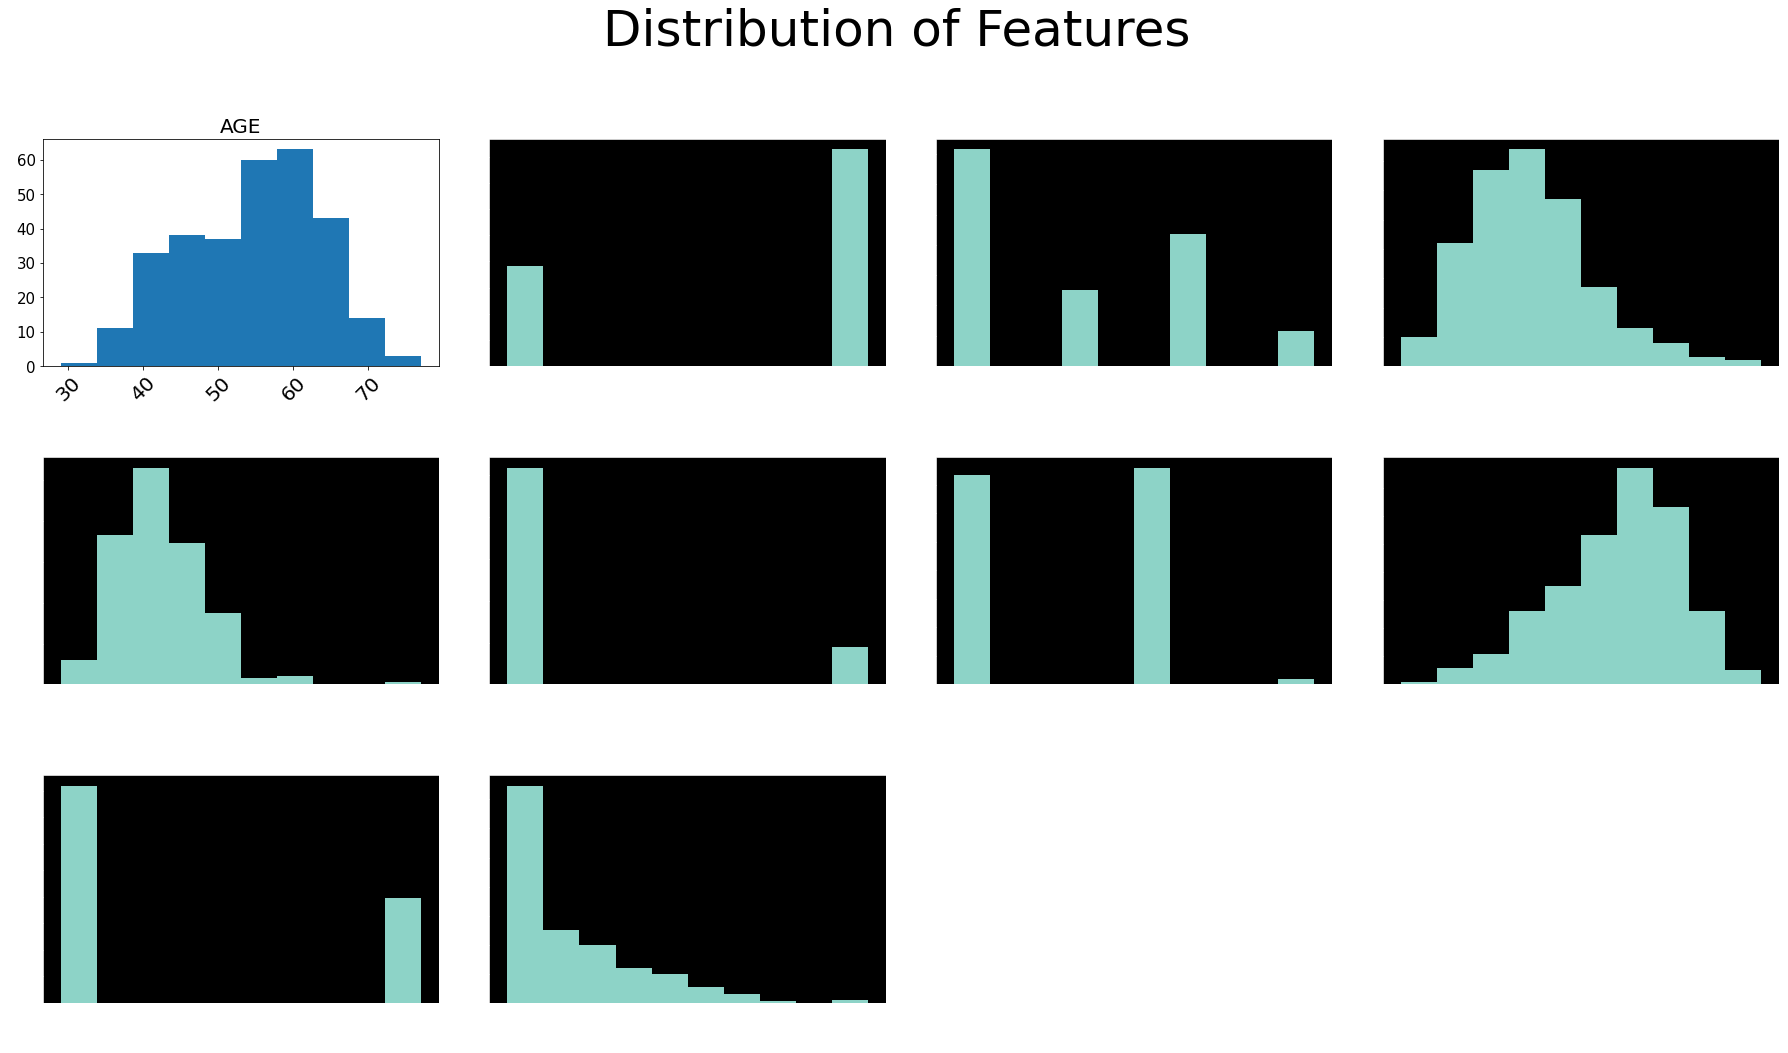

In [9]:
#plotting all the features 

from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

## Check For Null Values

In [10]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Create a new column - Age Groups

In [11]:
#UDF is used to create a reusable function in Spark. 

from pyspark.sql.functions import udf
def udf_multiple(age):
      if (age <= 25):
        return 'Under 25'
      elif (age >= 25 and age <= 35):
        return 'Between 25 and 35'
      elif (age > 35 and age < 50):
        return 'Between 36 and 49'
      elif (age >= 50):
        return 'Over 50'
      else: return 'N/A'

education_udf = udf(udf_multiple)
df=df.withColumn("Age_udf", education_udf('Age'))

### Age Groups Distribution

In [12]:
#distributing col. age

from pyspark.sql import functions as F
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
tab = df.select(['Age_udf','trestbps']).\
   groupBy('Age_udf').\
       agg(F.count('trestbps').alias('UserCount'),
           F.mean('trestbps').alias('trestbps_AVG'),
           F.min('trestbps').alias('trestbps_MIN'),
           F.max('trestbps').alias('trestbps_MAX')).\
       withColumn('total',sum(col('UserCount')).over(window)).\
       withColumn('Percent',col('UserCount')*100/col('total')).\
       drop(col('total')).sort(desc("Percent"))

In [13]:
tab.show()

+-----------------+---------+------------------+------------+------------+-----------------+
|          Age_udf|UserCount|      trestbps_AVG|trestbps_MIN|trestbps_MAX|          Percent|
+-----------------+---------+------------------+------------+------------+-----------------+
|          Over 50|      215|134.66046511627906|          94|         200|70.95709570957095|
|Between 36 and 49|       81|124.17283950617283|          94|         152|26.73267326732673|
|Between 25 and 35|        7|124.57142857142857|         118|         138| 2.31023102310231|
+-----------------+---------+------------------+------------+------------+-----------------+



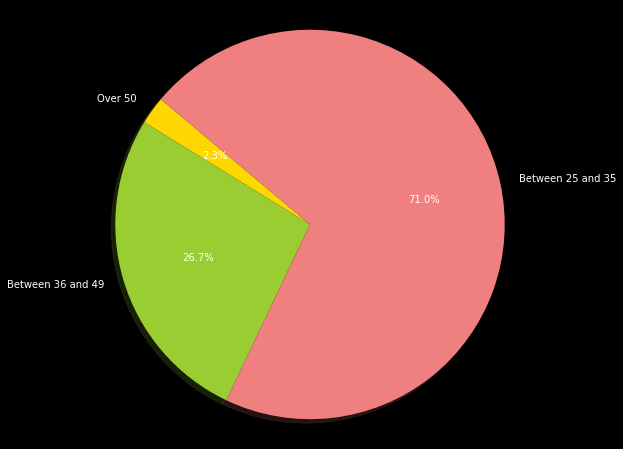

In [14]:
# Plotting the data of age distribution
labels = list(tab.select('Age_udf').distinct().toPandas()['Age_udf'])
sizes =  list(tab.select('Percent').distinct().toPandas()['Percent'])
colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red']
explode = (0.1, 0.0, 0 ,0.0 )  # explode 1st slice

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, explode= None , labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# Pearson Correlation

In [15]:
#Correlation coefficients are used to measure how strong a relationship is between two variables.
#Pearson’s correlation (also called Pearson’s R) is a correlation coefficient.
#Its value ranges from -1 to 1
#-1 means strong negatively relationship
#+1 means strong positively relationship
#0 means no relationship

numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df.toPandas().head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [16]:
#using pearson method and printing realtionshiop between various columns/features

col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


In [17]:
df=df.drop("Age")

In [18]:
df.show(4)

+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+-----------------+
|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|          Age_udf|
+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+-----------------+
|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|          Over 50|
|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|Between 36 and 49|
|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|Between 36 and 49|
|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|          Over 50|
+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+-----------------+
only showing top 4 rows



# Prepare Data for Machine Learning

## First Method 
### Step by Step apply 5 Estimators and Transformers and create new data frames

## a) StringIndexer

In [19]:
df2=df
df3=df

In [20]:
#Module in Spark ML Library
#converts string column to integers as Ml understands no. not string

stringIndexer = StringIndexer()\
                 .setInputCol ("Age_udf")\
                 .setOutputCol ("Age_udfIndex")

Age_udfIndex_model=stringIndexer.fit(df2)
Age_udfIndex_df=Age_udfIndex_model.transform(df2)
Age_udfIndex_df.toPandas().head(10)

,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,Age_udf,Age_udfIndex
0,1,3,145,233,1,0,150,0,2.3,0,0,1,1,Over 50,0.0
1,1,2,130,250,0,1,187,0,3.5,0,0,2,1,Between 36 and 49,1.0
2,0,1,130,204,0,0,172,0,1.4,2,0,2,1,Between 36 and 49,1.0
3,1,1,120,236,0,1,178,0,0.8,2,0,2,1,Over 50,0.0
4,0,0,120,354,0,1,163,1,0.6,2,0,2,1,Over 50,0.0
5,1,0,140,192,0,1,148,0,0.4,1,0,1,1,Over 50,0.0
6,0,1,140,294,0,0,153,0,1.3,1,0,2,1,Over 50,0.0
7,1,1,120,263,0,1,173,0,0.0,2,0,3,1,Between 36 and 49,1.0
8,1,2,172,199,1,1,162,0,0.5,2,0,3,1,Over 50,0.0
9,1,2,150,168,0,1,174,0,1.6,2,0,2,1,Over 50,0.0


In [21]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

## b) OneHotEncoderEstimator

In [22]:
#Module in Spark ML Library
#converts age_udfindex to column of binary vectors
#prepare an algorithm for better prediction

encoder = OneHotEncoder()\
         .setInputCols (["Age_udfIndex"])\
         .setOutputCols (["Age_encoded"])

encoder_model=encoder.fit(Age_udfIndex_df)
encoder_df=encoder_model.transform(Age_udfIndex_df)

encoder_df.toPandas().head()

,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,Age_udf,Age_udfIndex,Age_encoded
0,1,3,145,233,1,0,150,0,2.3,0,0,1,1,Over 50,0.0,"(1.0, 0.0)"
1,1,2,130,250,0,1,187,0,3.5,0,0,2,1,Between 36 and 49,1.0,"(0.0, 1.0)"
2,0,1,130,204,0,0,172,0,1.4,2,0,2,1,Between 36 and 49,1.0,"(0.0, 1.0)"
3,1,1,120,236,0,1,178,0,0.8,2,0,2,1,Over 50,0.0,"(1.0, 0.0)"
4,0,0,120,354,0,1,163,1,0.6,2,0,2,1,Over 50,0.0,"(1.0, 0.0)"


## c) VectorAssembler

In [23]:
#VectorAssember from Spark ML library is a module that allows to convert numerical features into a single vector

assembler = VectorAssembler()\
         .setInputCols (["Age_encoded","sex","cp",
                         "trestbps","chol",\
                         "fbs","restecg","thalach", "exang", "oldpeak", "slope", "ca", "thal"])\
         .setOutputCol ("vectorized_features")
        

assembler_df=assembler.transform(encoder_df)
assembler_df.toPandas().head()

,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,Age_udf,Age_udfIndex,Age_encoded,vectorized_features
0,1,3,145,233,1,0,150,0,2.3,0,0,1,1,Over 50,0.0,"(1.0, 0.0)","[1.0, 0.0, 1.0, 3.0, 145.0, 233.0, 1.0, 0.0, 1..."
1,1,2,130,250,0,1,187,0,3.5,0,0,2,1,Between 36 and 49,1.0,"(0.0, 1.0)","[0.0, 1.0, 1.0, 2.0, 130.0, 250.0, 0.0, 1.0, 1..."
2,0,1,130,204,0,0,172,0,1.4,2,0,2,1,Between 36 and 49,1.0,"(0.0, 1.0)","(0.0, 1.0, 0.0, 1.0, 130.0, 204.0, 0.0, 0.0, 1..."
3,1,1,120,236,0,1,178,0,0.8,2,0,2,1,Over 50,0.0,"(1.0, 0.0)","[1.0, 0.0, 1.0, 1.0, 120.0, 236.0, 0.0, 1.0, 1..."
4,0,0,120,354,0,1,163,1,0.6,2,0,2,1,Over 50,0.0,"(1.0, 0.0)","[1.0, 0.0, 0.0, 0.0, 120.0, 354.0, 0.0, 1.0, 1..."


## d) LabelIndexer

In [24]:
#Same as StringIndexer
#Converts string to integer

label_indexer = StringIndexer()\
         .setInputCol ("target")\  #Here we are applying labelindexer to target variable ie. target
         .setOutputCol ("label")

label_indexer_model=label_indexer.fit(assembler_df)
label_indexer_df=label_indexer_model.transform(assembler_df) ##Here HasDiabetes is transforming to Ml label

label_indexer_df.select("target","label").toPandas().head() #Printing the data through Pandas

,target,label
0,1,0.0
1,1,0.0
2,1,0.0
3,1,0.0
4,1,0.0


# e) StandardScaler

In [25]:
#Standardizes features by removing the mean and scaling to unit variance using column summary statistics.

scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model=scaler.fit(label_indexer_df)
scaler_df=scaler_model.transform(label_indexer_df)
pd.set_option('display.max_colwidth', 40)
scaler_df.select("vectorized_features","features").toPandas().head(5) #using vectorised_features as input and converting in features

,vectorized_features,features
0,"[1.0, 0.0, 1.0, 3.0, 145.0, 233.0, 1...","[2.199197431930312, 0.0, 2.145872906..."
1,"[0.0, 1.0, 1.0, 2.0, 130.0, 250.0, 0...","[0.0, 2.255826992942667, 2.145872906..."
2,"(0.0, 1.0, 0.0, 1.0, 130.0, 204.0, 0...","(0.0, 2.255826992942667, 0.0, 0.9689..."
3,"[1.0, 0.0, 1.0, 1.0, 120.0, 236.0, 0...","[2.199197431930312, 0.0, 2.145872906..."
4,"[1.0, 0.0, 0.0, 0.0, 120.0, 354.0, 0...","[2.199197431930312, 0.0, 0.0, 0.0, 6..."


## Second Method 

##  Create 5 Transformers / Estimators but apply all of them in a pipeline

In [26]:
#Pipeline is sequence of stages & each step has transformer
#Multiple columns are converted into one Pipeline

pipeline_stages=Pipeline()\
                .setStages([stringIndexer,encoder,assembler,label_indexer,scaler])
pipeline_model=pipeline_stages.fit(df3)
pipeline_df=pipeline_model.transform(df3) #data is transformed into pipeline as pipeline_df

In [27]:
pipeline_df.toPandas().head()

,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,Age_udf,Age_udfIndex,Age_encoded,vectorized_features,label,features
0,1,3,145,233,1,0,150,0,2.3,0,0,1,1,Over 50,0.0,"(1.0, 0.0)","[1.0, 0.0, 1.0, 3.0, 145.0, 233.0, 1...",0.0,"[2.199197431930312, 0.0, 2.145872906..."
1,1,2,130,250,0,1,187,0,3.5,0,0,2,1,Between 36 and 49,1.0,"(0.0, 1.0)","[0.0, 1.0, 1.0, 2.0, 130.0, 250.0, 0...",0.0,"[0.0, 2.255826992942667, 2.145872906..."
2,0,1,130,204,0,0,172,0,1.4,2,0,2,1,Between 36 and 49,1.0,"(0.0, 1.0)","(0.0, 1.0, 0.0, 1.0, 130.0, 204.0, 0...",0.0,"(0.0, 2.255826992942667, 0.0, 0.9689..."
3,1,1,120,236,0,1,178,0,0.8,2,0,2,1,Over 50,0.0,"(1.0, 0.0)","[1.0, 0.0, 1.0, 1.0, 120.0, 236.0, 0...",0.0,"[2.199197431930312, 0.0, 2.145872906..."
4,0,0,120,354,0,1,163,1,0.6,2,0,2,1,Over 50,0.0,"(1.0, 0.0)","[1.0, 0.0, 0.0, 0.0, 120.0, 354.0, 0...",0.0,"[2.199197431930312, 0.0, 0.0, 0.0, 6..."


## Third Method


In [28]:
#Convertingcategorical data to numeric data

categoricalColumns = ['Age_udf']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'target', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ["sex", 'cp', 'trestbps', 'chol','fbs','thalach','exang', "oldpeak", "slope", "ca","thal"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features")
stages += [assembler]
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
stages += [scaler]

In [29]:
cols = df.columns

In [30]:
cols

['sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'target',
 'Age_udf']

In [31]:
stages

[StringIndexer_1bc8db7e9f41,
 OneHotEncoder_54cc69331cc0,
 StringIndexer_51418ffab2c1,
 VectorAssembler_31206a57cb4d,
 StandardScaler_84c1c2e3c958]

In [32]:
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- Age_udf: string (nullable = true)



In [33]:
df.toPandas().head()

,label,features,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,Age_udf
0,0.0,"[2.199197431930312, 0.0, 2.145872906...",1,3,145,233,1,0,150,0,2.3,0,0,1,1,Over 50
1,0.0,"[0.0, 2.255826992942667, 2.145872906...",1,2,130,250,0,1,187,0,3.5,0,0,2,1,Between 36 and 49
2,0.0,"[0.0, 2.255826992942667, 0.0, 0.9689...",0,1,130,204,0,0,172,0,1.4,2,0,2,1,Between 36 and 49
3,0.0,"[2.199197431930312, 0.0, 2.145872906...",1,1,120,236,0,1,178,0,0.8,2,0,2,1,Over 50
4,0.0,"[2.199197431930312, 0.0, 0.0, 0.0, 6...",0,0,120,354,0,1,163,1,0.6,2,0,2,1,Over 50


# Train / Test Split

In [34]:
#training and splitting data into trained and test data

train, test = df.randomSplit([0.8, 0.2], seed = 2018)
#here data is split into 80% training data and 20% testing data. 
#Seed is any random no. which tells that same amount of data will be used afterwards

print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 236
Test Dataset Count: 67


In [35]:
#used to collect the identical data into groups on DataFrame and perform aggregate funs.
train.groupby("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     1|  125|
|     0|  111|
+------+-----+



# Model Training

In [36]:
#LR is statistical analysis method to predict a binary outcome, such as yes or no, based on prior observations of a data set

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.199197431930312, 0.0, 2.145872906...","[0.8048785257354305, -0.804878525735...",0.0,"[0.6910170767465111, 0.3089829232534..."
1,0.0,"(2.199197431930312, 0.0, 0.0, 0.0, 5...","[0.6312759082720405, -0.631275908272...",0.0,"[0.6527787142028165, 0.3472212857971..."
2,0.0,"(2.199197431930312, 0.0, 0.0, 0.0, 7...","[1.1135720127029283, -1.113572012702...",0.0,"[0.7527944451099529, 0.2472055548900..."
3,0.0,"(2.199197431930312, 0.0, 0.0, 0.0, 7...","[0.17118168371746423, -0.17118168371...",0.0,"[0.5426912227985029, 0.4573087772014..."
4,0.0,"(2.199197431930312, 0.0, 0.0, 0.0, 7...","[2.8216374209309034, -2.821637420930...",0.0,"[0.9438339315794269, 0.0561660684205..."


# Confusion Matrix

In [37]:
#A confusion matrix is a summary of prediction results 
#used to define the performance of a classification algorithm

class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[19  8]
 [ 6 34]]


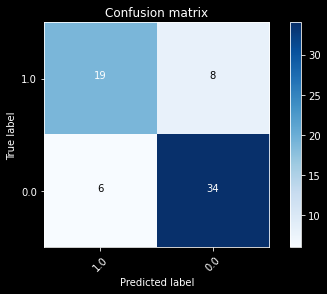

In [38]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [ ]:
#diagonal elements in matrix represents no. of points for which the predicted label is equal to the true label
#higher values of diagonals the better indiccation of correct prediction
#whereas off diagonal values are miss labelled by classifier

# Accuracy

In [39]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.7910447761194029


# Receiver Operating Characteristic Curve

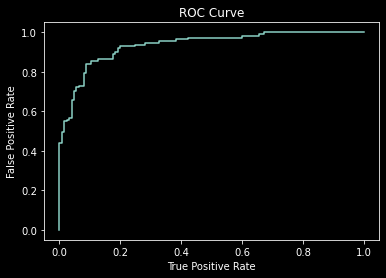

Training set areaUnderROC: 0.9347747747747751


In [40]:
#printing the training summary of trained model
#graph that show the performance of a classification model at all classification thresholds

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate') #FPR is the probability that an actual positive will test negative
plt.xlabel('True Positive Rate')  #TPR is the probability that an actual positive will test positive
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

# Model Evaluation

In [41]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions)) #Evaluating the output with optional parameters.

Test Area Under ROC 0.8601851851851852


# Saving File

In [42]:
lrModel.save('Heart.py')

In [43]:
from pyspark.ml.classification import LogisticRegressionModel

In [44]:
reg_model_loaded = LogisticRegressionModel.load('Heart.py')